# Tasks

Based on the task description provided, here's a structured step-by-step plan to complete your sentiment analysis mini-challenge. Each step is tailored to ensure compatibility with the challenge requirements and provided data.

---

### **Step 1: Setup and Dataset Selection**
1. **Select Dataset**:
   - Use one of the recommended datasets such as `sst2`, `amazon_polarity`, or `financial_phrasebank`.
   - Download the dataset using Hugging Face's `datasets` library.

2. **Environment Setup**:
   - Install required libraries: `transformers`, `datasets`, `scikit-learn`, `matplotlib`, `seaborn`, and `pandas`.
   - Set up `requirements.txt` or `environment.yml` file for reproducibility.

---

### **Step 2: Data Exploration and Preprocessing**
1. **Explore Dataset**:
   - Check for class distribution and balance (positive, negative, neutral).
   - Basic statistical analysis (e.g., sentence length, vocabulary size).

2. **Preprocess Data**:
   - Tokenize texts using a Hugging Face tokenizer.
   - Create nested data splits for different training set sizes.

---

### **Step 3: Baseline Model**
1. **Model Selection**:
   - Choose a pre-trained transformer model (e.g., `bert-base-uncased`) for sentiment classification.

2. **Training**:
   - Fine-tune the model on the hierarchical datasets.
   - Use a validation set or cross-validation for performance evaluation.
   - Record performance metrics (accuracy, F1 score).

---

### **Step 4: Text Embeddings and Weak Labeling**
1. **Generate Embeddings**:
   - Use a sentence-transformer model to create embeddings for all texts.
   - Explore embedding similarities visually (e.g., using t-SNE or UMAP).

2. **Weak Labeling**:
   - Implement algorithms to assign labels based on embedding similarities.
   - Evaluate the quality of weak labels (e.g., agreement with ground truth).

---

### **Step 5: Enhanced Model Training**
1. **Combine Labels**:
   - Integrate weak labels with manual labels for training.
   - Use all weak labels where manual labels are unavailable.

2. **Training**:
   - Train the model using both hard and weak labels.
   - Evaluate and compare performance against the baseline.

---

### **Step 6: Performance Analysis**
1. **Learning Curve**:
   - Plot model performance vs. training data size.
   - Analyze improvements from weak labels.

2. **Comparison**:
   - Compare results of baseline and weakly labeled models.
   - Analyze the trade-off between annotation cost and performance.

---

### **Step 7: Reporting**
1. **Documentation**:
   - Create well-commented and structured notebooks.
   - Save a rendered `.html` or `.pdf` version of the analysis.

2. **Repository**:
   - Prepare a clean, documented repository including all code and dependencies.

3. **Discussion of AI Usage**:
   - Document how tools like ChatGPT assisted in the project, with examples.

---

Would you like me to begin implementing this step-by-step solution, starting with the environment setup and dataset loading?

Dataset Summary

The Stanford Sentiment Treebank is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11,855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

# Imports and Setup

In [6]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from pipeline_utils import *

device = get_device()

Using MPS (Metal Performance Shaders)
Selected device: mps


In [7]:
# load nested train splits (all files in /data/nested_splits)
nested_splits = {}
splits_dir = "../data/nested_splits"
split_sizes = ["1%", "10%", "30%", "50%", "75%", "100%"]
nested_splits = {size: pd.read_csv(f"{splits_dir}/train_split_{size}.csv") for size in split_sizes}

df_val = pd.read_csv("../data/val.csv")
df_test = pd.read_csv("../data/test.csv")

## Baseline Model

In [8]:
# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize Validation and Test Sets
validation_ds = convert_and_tokenize(df_val, tokenizer)
test_ds = convert_and_tokenize(df_test, tokenizer)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

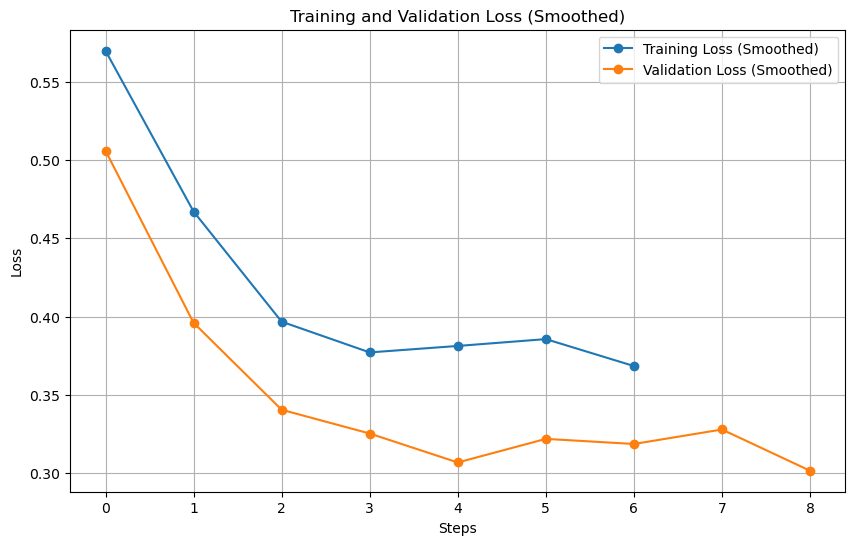

Early stopping triggered after 2 evaluations.


In [9]:
metrics = []
for size, train_df in nested_splits.items():
    print(f"Training with {size} of data...")
    train_ds = convert_and_tokenize(train_df, tokenizer)

    # Calculate total training steps for the callback
    total_steps = len(train_ds) // 8  # Assuming batch size of 8

    # Train and collecft metrics
    _, split_metrics = train_model(train_ds, validation_ds, total_steps, device)
    split_metrics["split_size"] = size
    metrics.append(split_metrics)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../data/baseline_metrics.csv", index=False)

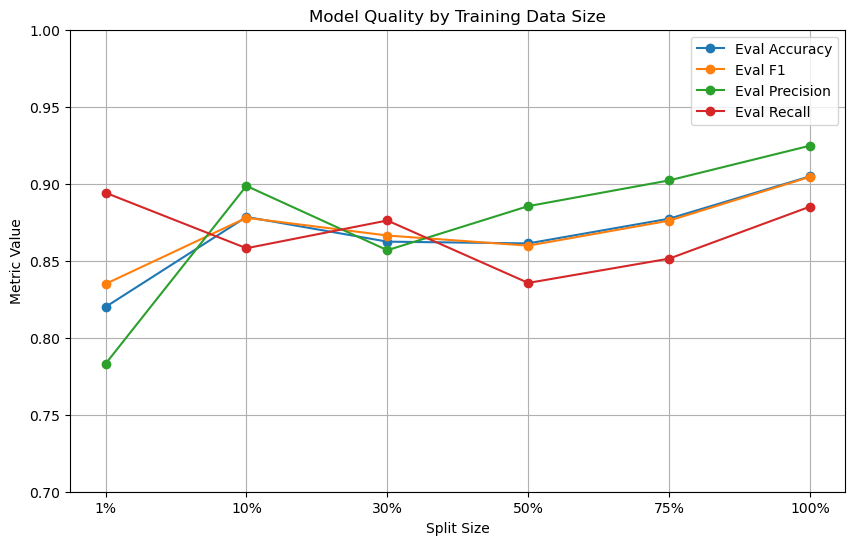

In [17]:
plot_metrics(metrics_df, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

The plot shows how evaluation metrics (accuracy, F1, precision, and recall) evolve as the training dataset size increases:

1. **1% Split**:
   - Metrics are relatively lower due to limited data for learning meaningful patterns.
   - Recall is the highest, indicating the model is identifying more true positives but at the expense of some false positives

2. **10% Split**:
   - Significant improvement in precision accuracy and F1 score.
   - The model benefits from the increased training data, achieving better balance between precision and recall.

3. **30% Split**:
   - Dip in precision while other metrics remain pretty steady. This could indicate slight overfitting or under-optimization in this split.

4. **50% to 100% Splits**:
   - Metrics consistently improve with more data.
   - Recall, precision, F1 score and accuracy stabilize, with recall showing the most significant gains as the model learns to generalize better.

### **General Observations**:
- Adding more data helps the model learn more robust patterns, leading to steady improvements across all metrics.
- Precision, accuracy and F1 score clearly trend upward, indicating a good balance in classification performance.
- The gap between metrics narrows with larger splits, suggesting better overall generalization.

## Text Embeddings

texts need to be represented in numeric form as embedding vectors generated by means of a language model. Then, similarities between embedding vectors can be quantified and a strategy can be developed to retrieve similar labelled texts for a given unlabelled text. Specific model architectures such as sentence-transformers have been trained especially for semantic representation of entire sentences. Apply such models for generating text embeddings and explore the results quantitatively and qualitatively. To inspect the embeddings’ quality, you may calculate and visualize similarities

## Weak Labeling

Weak labeling is a technique used to assign pseudo-labels to unlabeled data based on predefined rules or heuristics. In this case, it was applied to the `test_df`, which originally contained only `-1` values, indicating that the dataset was unlabeled and unsuitable for evaluation. To address this, we implemented a rule-based weak labeling function that assigns a label of `1` (positive) to sentences containing words like "good" or "excellent" and a label of `0` (negative) to those with words like "bad" or "terrible." Sentences that do not match any rule were labeled `-1` and subsequently removed from the dataset. This allowed us to create a usable test dataset with meaningful labels, enabling the evaluation of the model despite the absence of ground-truth annotations in the original test data.